## Sublimation over snow and ice

In [8]:
import math
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

%matplotlib inline


def EB_fluxes(T_0,T_a,f,albedo,G,p,rho,U_L,z,z_0):
    """ This function calculates the energy fluxes from the following quantities:
    
    Input: 
    T_0       : Surface temperature, which is optimized [K]
    f         : Relative humdity as fraction, e.g. 0.7 [-]
    albedo    : Snow albedo [-]
    G         : Shortwave radiation [W m^-2]
    p         : Air pressure [hPa]
    rho       : Air denisty [kg m^-3]
    z         : Measurement height [m]
    z_0       : Roughness length [m]
    
    """
    
    # Some constants
    c_p = 1004.0      # specific heat [J kg^-1 K^-1]
    kappa = 0.40      # Von Karman constant
    sigma = 5.67e-8   # Stefan-Bolzmann constant
    
    # Aerodynamic roughness lengths
    z0t = z_0/100  # sensible heat
    z0q = z_0/10   # moisture
    
    # Bulk coefficients
    #Cs_t = np.power(kappa,2.0) / ( np.log(z/z_0) * np.log(z/z0t) )
    #Cs_q = np.power(kappa,2.0) / ( np.log(z/z_0) * np.log(z/z0q) )  
    Cs_t = np.power(kappa,2.0) / ( np.log(z/z_0) * np.log(z/z_0) )
    Cs_q = np.power(kappa,2.0) / ( np.log(z/z_0) * np.log(z/z_0) )  
    
    # Mixing ratio at measurement height and surface
    q2 = (f * 0.622 * (E_sat(T_a) / (p - E_sat(T_a))))
    q0 = (0.622 * (E_sat(T_0) / (p - E_sat(T_0))))
        
    # Correction factor for incoming longwave radiation
    eps_cs = 0.23 + 0.433 * np.power(100*(f*E_sat(T_a))/T_a,1.0/8.0)
    
    # Select the appropriate latent heat constant
    if T_0<=273.16:
        L = 2.83e6 # latent heat for sublimation
    else:
        L = 2.50e6 # latent heat for vaporization

    # Calculate turbulent fluxes
    H_0 = rho * c_p * (1.0/0.8) * Cs_t * U_L * (T_0-T_a)
    E_0 = rho * L * (1.0/0.8) * Cs_q * U_L * (q0-q2)
    # Calculate turbulent fluxes
    #H_0 = rho * c_p  * Cs_t * U_L * (T_0-T_a)
    #E_0 = rho * L * Cs_q * U_L * (q0-q2)
    
    # Calculate radiation budget
    L_d = eps_cs * sigma * (T_a)**4
    L_u = sigma * (T_0)**4 
    Q_0 = (1-albedo)*G + L_d - L_u

    return (Q_0,H_0,E_0)

def E_sat(T):
    if T>=273.16:
        # over water
        Ew = 6.112 * np.exp((17.67*(T-273.16)) / ((T-29.66)))
    else:
        # over ice
        Ew = 6.112 * np.exp((22.46*(T-273.16)) / ((T-0.55)))
    return Ew
    
    
def optim_T0(x,T_a,f,albedo,G,p,rho,U_L,z,z_0):
    """ Optimization function for surface temperature:
    
    Input: 
    T_0       : Surface temperature, which is optimized [K]
    f         : Relative humdity as fraction, e.g. 0.7 [-]
    albedo    : Snow albedo [-]
    G         : Shortwave radiation [W m^-2]
    p         : Air pressure [hPa]
    rho       : Air denisty [kg m^-3]
    z         : Measurement height [m]
    z_0       : Roughness length [m]
    
    """
    
    Q_0, H_0, E_0 = EB_fluxes(x,T_a,f,albedo,G,p,rho,U_L,z,z_0)
    
    # Get residual for optimization
    res = (Q_0-H_0-E_0)
    
    # guarantee that res-term is always positiv for optimization
    if res<0.0:
        res=9999
    
    # return the residuals
    return res




# Ablation diagrams

We can calculate the ablation over a snow surface with the established model for different cases, if the unknown quantities snow albedo , incoming shortwave radiation, air temperature, humidity and presssure are known. In the following, we use so-called ablation diagrams which help to illustrate the relationships between sublimation and its dependence on the influencing variables. The ablation diagrams presented here show the relationship between air temperature and melt. This is only possible if some parameters are assumed to be constant, e.g. albedo and roughness length. Ablation is thus only controlled by the incoming short-wave radiation, wind speed, air temperature and humidity.

In [9]:
from matplotlib.ticker import ScalarFormatter


def ablation_diagram():
    
    # Define simulation parameters
    rho = 1.2        # Air density [kg m^-3]
    rho_w = 1000.0   # Water density [kg m^-3]
    G = 700.0        # Incoming shortwave radiation [W m^-2] 
    U_L = 2.0        # Wind speed [m s^-1]
    z = 2.0          # Measurement height [m]
    z_0 = 1e-3       # Aerodynamic roughness length [m]
    p = 700.0        # Surface air pressure [hPa]
    albedo = 0.5     # Snow albedo [-]
    dt = 3600        # Time step used to calculate melt rates [s]

    # Create figure
    fig, ax = plt.subplots(figsize=(20, 10))
    c = 1
    colors = plt.cm.Blues(np.linspace(0,1,4))

    # Make loop over different relative humidity values
    for f in [0.9,0.7,0.4]:

        # Define the temperature range
        T_rng = np.arange(253,283,1)

        # Create empty arrays
        subl = []
        M = []
        total = []
        T0_arr = []

        # Make loop over temperature range
        for T_a in T_rng:

            # Optimize for surface temperature
            res = minimize(optim_T0,x0=240.0,args=(T_a,f,albedo,G,p,rho,U_L,z,z_0),bounds=((200,273.16),),\
                       options={'maxiter':1000},method='L-BFGS-B',tol=1e-10)

            # Assign optimization result to variable T_0
            T_0 = res.x

            # Get the melt and sublimation rates
            Q_0, H_0, E_0 = EB_fluxes(res.x,T_a,f,albedo,G,p,rho,U_L,z,z_0)

            # Calculate melt and sublimation terms [mm per time]
            melt = (((Q_0-H_0-E_0)/(0.33e6*1000.0))*dt)*1000
            sublimation = ((E_0/(2.83e6*1000))*dt)*1000

            # Append the rates for each temperature value to result arrays
            if (T_0<273.16): # Sublimation if T<273.16
                total.append(sublimation)
                subl.append(sublimation)
                M.append(0)
            else:            # if not, surface melt
                total.append(melt+sublimation)   
                subl.append(sublimation)
                M.append(melt)

            T0_arr.append(T_0)

        # Plot results for each relative humidity value
        ax.plot(T_rng-273.16,total,label=f*100, color=colors[c])


        # Plots for melting surfaces and sublimation
        #ax.plot(T_rng-273.16,subl,label=f*100)
        #ax.plot(T_rng-273.16,M,label=f*100)    

        # Add axis and legend
        leg = ax.legend(prop={'size': 20})
        leg.set_title('Relative humidity',prop={'size':22})
        ax.set_xlabel('$T_a$ in ºC', fontsize=24)
        ax.set_ylabel(r'Ablation in mm h$^{-1}$', fontsize=24)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_yscale('log')

        plt.text(5,1,r'G=%g Wm$^{-2}$'%(G), fontsize=24)
        plt.text(5,0.75,r'$U_L$=%.2f'%U_L, fontsize=24)

        # Increase color
        c=c+1





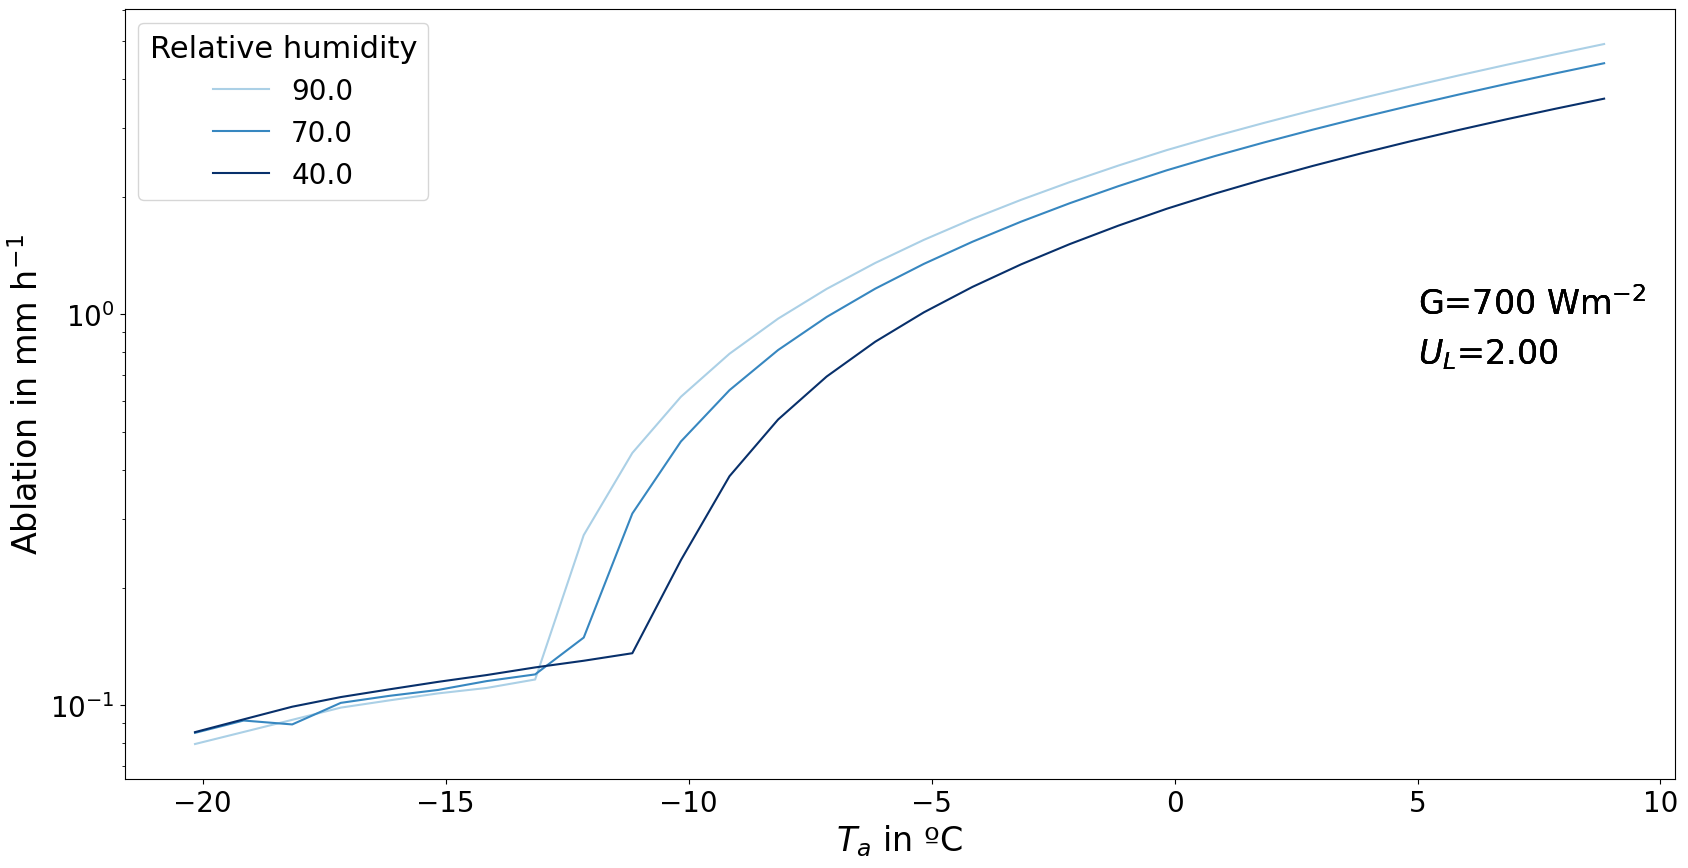

In [10]:
ablation_diagram()

# Some questions:

Why is there a such pronounced kink in the three curves? Why isn't it always at the same point?

Why does the melt close below the bend with increasing humidity?

Why does the melt suddenly rise rapidly above this point?

Why does the melt increase above the bend with increasing humidity?

# The next ablation diagram shows the dependence of the ablation on the wind velocity


In [ ]:
The three curves overlap at one point. What is the reason for this

In [27]:

def ablation_diagram_2():

    # Define simulation parameters
    rho = 1.2        # Air density [kg m^-3]
    rho_w = 1000.0   # Water density [kg m^-3]
    G = 700.0        # Incoming shortwave radiation [W m^-2] 
    U_L = 2.0        # Wind speed [m s^-1]
    z = 2.0          # Measurement height [m]
    z_0 = 1e-3       # Aerodynamic roughness length [m]
    p = 700.0        # Surface air pressure [hPa]
    albedo = 0.5     # Snow albedo [-]
    dt = 3600        # Time step used to calculate melt rates [s]


    # Create figure
    fig, ax = plt.subplots(figsize=(20, 10))
    c = 1
    colors = plt.cm.Blues(np.linspace(0,1,4))

    # Make loop over different relative humidity values
    #for f in [1.0,0.7,0.4]:
    for U_L in [2.0,4.0,6.0]:
        f = 0.4
        # Define the temperature range
        T_rng = np.arange(253,283,1)

        # Create empty arrays
        subl = []
        M = []
        total = []


        # Make loop over temperature range
        for T_a in T_rng:

            # Optimize for surface temperature
            res = minimize(optim_T0,x0=240.0,args=(T_a,f,albedo,G,p,rho,U_L,z,z_0),bounds=((200,273.16),),\
                       options={'maxiter':1000},method='L-BFGS-B',tol=1e-10)

            # Assign optimization result to variable T_0
            T_0 = res.x

            # Get the melt and sublimation rates
            Q_0, H_0, E_0 = EB_fluxes(res.x,T_a,f,albedo,G,p,rho,U_L,z,z_0)

            # Calculate melt and sublimation terms [mm per time]
            melt = (((Q_0-H_0-E_0)/(0.33e6*1000.0))*dt)*1000
            sublimation = ((E_0/(2.83e6*1000))*dt)*1000

            # Append the rates for each temperature value to result arrays
            if (T_0<273.16): # Sublimation if T<273.16
                total.append(sublimation)
                subl.append(sublimation)
                M.append(0)
            else:            # if not, surface melt
                total.append(melt+sublimation)   
                subl.append(sublimation)
                M.append(melt)

        # Plot results for each relative humidity value
        #ax.plot(T_rng-273.16,subl,label=f*100)
        #ax.plot(T_rng-273.16,M,label=f*100)
        ax.plot(T_rng-273.16,total,label=U_L, color=colors[c])
        c=c+1

        # Add axis and legend
        leg = ax.legend(prop={'size': 20})
        leg.set_title('Wind velocity',prop={'size':22})
        plt.xlabel('$T_a$ in ºC', fontsize=24)
        plt.ylabel(r'Ablation in mm h$^{-1}$', fontsize=24)
        ax.tick_params(axis='both', which='major', labelsize=20)
        plt.yscale('log')
        ax.set_yticks([0.01,0.02,0.05,0.1,0.2,0.5,1,2,5])
        plt.text(5,1,r'G=%g Wm$^{-2}$'%(G), fontsize=24)
        plt.text(5,0.7,r'$f$=%.2f'%f, fontsize=24)

    plt.show()


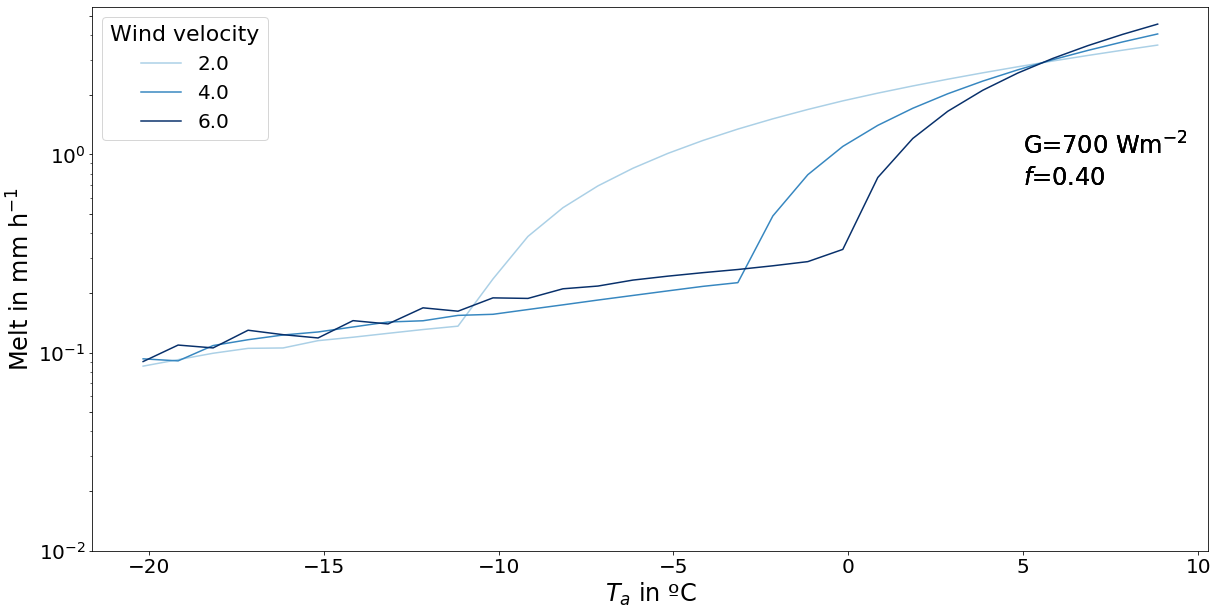

In [28]:
ablation_diagram_2()

# Some questions:

Why does sublimation increase with increasing wind speed?

The three curves overlap at one point. What is the reason for this?

# Exercises

Use the ablation diagram code to investigate the dependence of ablation on global radiation. Which statement 
about the sublimation can be derived from the diagram?